### Structure of the Code

* **Loading and Inspecting the Data**
* **Data Cleaning and Merging**
* **Data Preparation: Feature Extraction and Transformation**
* **Processing items_properties Files**
* **Splitting Data into Training and Test Sets**
* **Model Training: Applying SVD Model**
* **Evaluating Model Performance (Calculating RMSE)**
  * Evaluating the Average Error Ratio
  * Visualization of Results
* **Finding Similar Users Using KNN Model**
  * Cross-Validation and Hyperparameter Optimization 
* **Recommendation Functions***
  * Collaborative Filtering: Making Recommendations Using SVD and KNN Models
  * Content-Based Filtering Using Item Properties
  * Finding Similar Items Using Annoy 

### Requirements

In [1]:
%pip install pandas
%pip install scikit-learn
%pip install scipy
%pip install numpy
%pip install matplotlib
%pip install annoy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mithat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mithat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mithat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mithat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mithat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Mithat\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# **Loading and Inspecting the Data**

In [2]:
import pandas as pd

# Load the data
events = pd.read_csv('dataset/events.csv')
item_properties = pd.read_csv('dataset/item_properties.csv')

# Display the first few rows
print("Events DataFrame:")
print(events.head())
print("\nItem Properties DataFrame:")
print(item_properties.head())

Events DataFrame:
       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN

Item Properties DataFrame:
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513


# **Data Cleaning and Merging**

In [3]:
# Check for missing values
print("Events missing values:\n", events.isnull().sum())
print("Item Properties missing values:\n", item_properties.isnull().sum())


# Clean missing values
events = events.dropna()
item_properties = item_properties.dropna()

Events missing values:
 timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64
Item Properties missing values:
 timestamp    0
itemid       0
property     0
value        0
dtype: int64


# **Data Preparation: Feature Extraction and Transformation**

In [4]:
# Convert timestamp to datetime format
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

# Weighting event types
event_type_mapping = {'view': 1, 'addtocart': 5, 'transaction': 10}
events['event'] = events['event'].map(event_type_mapping)

# Create user-item matrix (weighted)
user_item_matrix = events.pivot_table(index='visitorid', columns='itemid', values='event', aggfunc='sum', fill_value=0)

print(user_item_matrix.head())

itemid     15      19      25      42      147     168     199     212     \
visitorid                                                                   
172             0       0       0       0       0       0       0       0   
186             0       0       0       0       0       0       0       0   
264             0       0       0       0       0       0       0       0   
419             0       0       0       0       0       0       0       0   
539             0       0       0       0       0       0       0       0   

itemid     233     304     ...  466319  466321  466342  466443  466464  \
visitorid                  ...                                           
172             0       0  ...       0       0       0       0       0   
186             0       0  ...       0       0       0       0       0   
264             0       0  ...       0       0       0       0       0   
419             0       0  ...       0       0       0       0       0   
539             

# **Processing items_properties Files**

In [5]:
item_properties_first = item_properties.drop_duplicates(subset=['itemid', 'property'], keep='first')

# Pivot the item_properties file to create a feature matrix for each product
item_properties_pivot = item_properties_first.pivot(index='itemid', columns='property', values='value')
print("Item Properties Pivot DataFrame:")
print(item_properties_pivot.head())

Item Properties Pivot DataFrame:
property       0    1   10  100 1000 1001 1002 1003 1004 1005  ...  992  993  \
itemid                                                         ...             
0            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1         769062  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

property  994  995  996  997  998  999 available categoryid  
itemid                                                       
0         NaN  NaN  NaN  NaN  NaN  NaN         0        NaN  
1         NaN  NaN  NaN  NaN  NaN  NaN         1       1114  
2         NaN  NaN  NaN  NaN  NaN  NaN       NaN       1305  
3         NaN  NaN  NaN  NaN  NaN  NaN         0       1171  
4         NaN  NaN  NaN  NaN  NaN 

# **Splitting Data into Training and Test Sets**

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the user-item matrix into training and test sets
train_data, test_data = train_test_split(user_item_matrix, test_size=0.2, random_state=42)

# De-mean the training data
R_train = train_data.values
user_ratings_mean_train = np.mean(R_train, axis=1)
R_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

# De-mean the test data
R_test = test_data.values
user_ratings_mean_test = np.mean(R_test, axis=1)
R_demeaned_test = R_test - user_ratings_mean_test.reshape(-1, 1)

# **Model Training: Applying SVD Model**

In [7]:
from scipy.sparse.linalg import svds

# Apply SVD to the training data
U, sigma, Vt = svds(R_demeaned_train, k=50)
sigma = np.diag(sigma)

# Reconstruct the user and item matrices
all_user_predicted_ratings_train = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean_train.reshape(-1, 1)
preds_df_train = pd.DataFrame(all_user_predicted_ratings_train, columns=train_data.columns)

# Calculate predictions for the test set
U_test, sigma_test, Vt_test = svds(R_demeaned_test, k=50)
sigma_test = np.diag(sigma_test)

all_user_predicted_ratings_test = np.dot(np.dot(U_test, sigma_test), Vt_test) + user_ratings_mean_test.reshape(-1, 1)
preds_df_test = pd.DataFrame(all_user_predicted_ratings_test, columns=test_data.columns)

# **Evaluating Model Performance (Calculating RMSE)**

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Evaluate performance on the training set
predicted_ratings_train = preds_df_train.values
true_ratings_train = train_data.values
mask_train = true_ratings_train != 0
mse_train = mean_squared_error(true_ratings_train[mask_train], predicted_ratings_train[mask_train])
rmse_train = sqrt(mse_train)
print(f"RMSE on Training Data: {rmse_train}")

# Evaluate performance on the test set
predicted_ratings_test = preds_df_test.values
true_ratings_test = test_data.values
mask_test = true_ratings_test != 0
mse_test = mean_squared_error(true_ratings_test[mask_test], predicted_ratings_test[mask_test])
rmse_test = sqrt(mse_test)
print(f"RMSE on Test Data: {rmse_test}")

RMSE on Training Data: 9.381091857219515
RMSE on Test Data: 8.392608235973468


In [9]:
print("Range of actual values: ", test_data.values.min(), test_data.values.max())

Range of actual values:  0 140


### Evaluating the Average Error Ratio

In [10]:
value_range = test_data.values.max() - test_data.values.min()
average_error_ratio = rmse_test / value_range
print(f"Average Error Ratio: {average_error_ratio:.2%}")

Average Error Ratio: 5.99%


### Visualization of Results

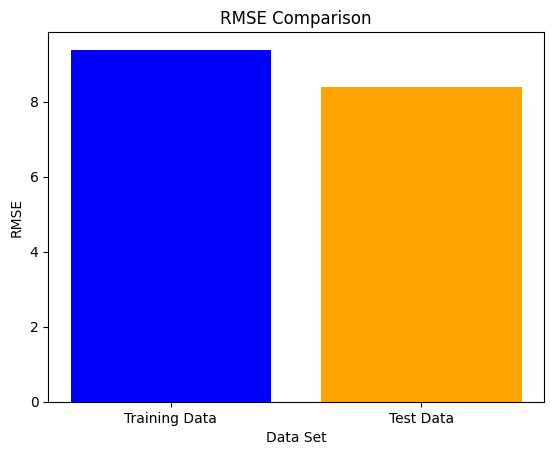

In [11]:
import matplotlib.pyplot as plt

# Visualize RMSE values
rmse_values = [rmse_train, rmse_test]
labels = ['Training Data', 'Test Data']

plt.bar(labels, rmse_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.show()

# **Finding Similar Users Using KNN Model**

In [12]:
from sklearn.neighbors import NearestNeighbors

# Create and train the KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(U)

NearestNeighbors(algorithm='brute', metric='cosine')

## **Cross-Validation and Hyperparameter Optimization**

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

# Parameter search for KNN model
param_grid = {
    'n_neighbors': [10, 20, 30, 40, 50],
    'metric': ['cosine', 'euclidean']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(U, np.argmax(R_train, axis=1))

print(f"Best parameters: {grid_search.best_params_}")

c:\Users\Mithat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'metric': 'cosine', 'n_neighbors': 10}


In [14]:
kf = KFold(n_splits=5)
errors = []

R = user_item_matrix.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

for train_index, test_index in kf.split(R):
    train_fold = R[train_index]
    test_fold = R[test_index]
    
    # Prepare the train fold
    user_ratings_mean_train_fold = np.mean(train_fold, axis=1)
    R_demeaned_train_fold = train_fold - user_ratings_mean_train_fold.reshape(-1, 1)

    # Apply SVD
    U_train_fold, sigma_train_fold, Vt_train_fold = svds(R_demeaned_train_fold, k=50)
    sigma_train_fold = np.diag(sigma_train_fold)

    # Calculate predicted user-item matrix for the train fold
    all_user_predicted_ratings_train_fold = np.dot(np.dot(U_train_fold, sigma_train_fold), Vt_train_fold) + user_ratings_mean_train_fold.reshape(-1, 1)
    
    # Calculate predictions for the test set and check indices
    valid_test_indices = [i for i in test_index if i < all_user_predicted_ratings_train_fold.shape[0]]
    if not valid_test_indices:
        print(f"Skipping fold due to invalid test indices: {test_index}")
        continue
    
    test_pred_fold = all_user_predicted_ratings_train_fold[valid_test_indices]
    test_fold_valid = test_fold[:len(valid_test_indices)]
    
    # Calculate the error between true and predicted values (using masks)
    mask = test_fold_valid != 0
    mse_fold = mean_squared_error(test_fold_valid[mask], test_pred_fold[mask])
    errors.append(sqrt(mse_fold))

# Calculate and print average RMSE
print(f"Cross-Validation RMSE: {np.mean(errors)}")

Skipping fold due to invalid test indices: [ 9376  9377  9378 ... 11716 11717 11718]
Cross-Validation RMSE: 10.904927571608859


# **Recommendation Functions** 

### Collaborative Filtering: Making Recommendations Using SVD and KNN Models

In [15]:
def recommend_items_combined(user_id, n_items=5):
    user_index = list(user_item_matrix.index).index(user_id)
    user_vector = U[user_index].reshape(1, -1)

    # Find similar users
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=n_items+1)
    similar_users = indices.flatten()

    # Validate indices to avoid out-of-bound errors
    valid_similar_users = [i for i in similar_users if i < preds_df_test.shape[0]]
    
    if len(valid_similar_users) == 0:
        print("No valid similar users found.")
        return []

    # Aggregate ratings from valid similar users
    similar_users_ratings = preds_df_test.iloc[valid_similar_users].mean(axis=0)

    # Filter out already rated items
    user_rated_items = user_item_matrix.columns[user_item_matrix.iloc[user_index] > 0]
    recommendations = similar_users_ratings.drop(user_rated_items).sort_values(ascending=False).head(n_items)

    return recommendations.index.tolist()

# Example recommendation
user_id = user_item_matrix.index[0]
recommendations = recommend_items_combined(user_id)
print(f"Recommendations for user {user_id}: {recommendations}")

Recommendations for user 172: [124081, 125275, 63406, 171878, 192043]


### Content-Based Filtering Using Item Properties

In [16]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

# item_properties is already merged in the Data Cleaning and Merging step
# Remove duplicate entries, keeping only the first occurrence
item_properties_first = item_properties.drop_duplicates(subset=['itemid', 'property'], keep='first')

# Pivot the item_properties file to create a feature matrix for each product
item_properties_pivot = item_properties_first.pivot(index='itemid', columns='property', values='value')

# Apply Label Encoding
label_encoders = {}
for column in item_properties_pivot.columns:
    label_encoders[column] = LabelEncoder()
    item_properties_pivot[column] = label_encoders[column].fit_transform(item_properties_pivot[column].astype(str))

item_properties_pivot = item_properties_pivot.fillna(0)

# Convert to sparse matrix
item_properties_sparse = csr_matrix(item_properties_pivot.values)

print("Sparse Matrix Created")

Sparse Matrix Created


### Scalability

To handle large datasets efficiently, we utilize the ANN (Approximate Nearest Neighbors) algorithm with the Annoy library. This approach allows us to quickly find similar items without the computational overhead associated with exact similarity calculations.


In [17]:
from annoy import AnnoyIndex
import random

# Determine the number of features
f = item_properties_pivot.shape[1]

# Create Annoy index
t = AnnoyIndex(f, 'angular')

# Add each item to the Annoy index
for i in range(len(item_properties_pivot)):
    t.add_item(i, item_properties_pivot.iloc[i, :].tolist())

t.build(10)  # Build 10 trees

# Function to find similar items
def get_similar_items_ann(item_id, n=10):
    item_index = item_properties_pivot.index.get_loc(item_id)
    similar_indices = t.get_nns_by_item(item_index, n)
    similar_items = item_properties_pivot.index[similar_indices].tolist()
    return similar_items

# Example of finding similar items
item_id = random.choice(list(item_properties_pivot.index ))
similar_items = get_similar_items_ann(item_id)
print(f"Similar items to {item_id}: {similar_items}")


Similar items to 438304: [438304, 355306, 157278, 148609, 316705, 220603, 429693, 392159, 108003, 71720]
